In [1]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torchvision import transforms
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from torch.utils.data import DataLoader
from pathlib import Path

from data_preprocessing import *
from dataset import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device).requires_grad_(False)

In [4]:
def load_image(p):
    return Image.open(p).convert("RGB").resize((256, 256))

In [5]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     lambda x: x * 2.0 - 1.0
# ])
# data_to_latents(vae, "./images/train/", Path("./latent_images/train/"), transform=transform, batch_size=5)


In [6]:
dl = latent_dataloader(Path("./latent_images/train/"), batch_size=5, shuffle=True)

In [7]:
def pil_to_latents(img, device):
    img = transforms.ToTensor()(img).unsqueeze(0) * 2.0 - 1.0
    img = img.to(device=device, dtype=torch.float32)
    latent_img = vae.encode(img).latent_dist.sample() * 0.18215
    return latent_img

In [8]:
def latents_to_pil(latents):     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [9]:
X, y = next(iter(dl))

images = latents_to_pil(X.to(device))

fig = plt.figure(figsize=(256, 256))
print(y)
for i in range(1, len(images)+1):
    fig.add_subplot(1, 5, i)
    plt.imshow(images[i-1])
    plt.axis("off")
plt.show()

tensor([0, 0, 1, 1, 0])


In [10]:
unet = UNet2DModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D", 
        "AttnDownBlock2D", 
        "AttnDownBlock2D", 
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D", 
        "AttnUpBlock2D", 
        "UpBlock2D"
    ),
    class_embed_type="timestep"
).to(device)

In [11]:
lr = 1e-3
loss_fn = nn.MSELoss()
optimizer = AdamW(unet.parameters(), lr=lr)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
losses = []

def train(model, epochs=None):
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(dl))
    for epoch in range(epochs):
        train_running_loss = 0
        model.train()
        for latent_images, labels in dl:
            
            latent_images = latent_images.to(device)
            labels = labels.to(device)

            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latent_images.shape[0], )).to(device)
            noise = torch.randn_like(latent_images).to(device)
            noisy_images = noise_scheduler.add_noise(latent_images, noise, timesteps)

            pred_noise = model(noisy_images, timesteps, labels).sample

            loss = loss_fn(pred_noise, noise)
            losses.append(loss.item())
            train_running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # scheduler.step()
        print(f"Epoch={epoch} | Train Loss: {train_running_loss/len(dl)}")

        if epoch % 10 == 0:
            model.eval()
            noisy_images = torch.randn_like(latent_images).to(device)
            labels = torch.randint(2, size=(latent_images.shape[0],)).to(device)

            for timestep in noise_scheduler.timesteps:
                with torch.inference_mode():
                    noise = model(noisy_images, timestep, labels).sample
                noisy_images = noise_scheduler.step(noise, timestep, noisy_images).prev_sample

            images = latents_to_pil(noisy_images)
            fig = plt.figure()
            print(labels)
            for i in range(1, len(images)+1):
                fig.add_subplot(1, 5, i)
                plt.imshow(images[i-1])
                plt.axis("off")
            plt.show()        

Epoch=0 | Train Loss: 0.9885165691375732
tensor([1, 1, 0, 1, 0], device='cuda:0')


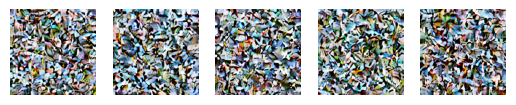

Epoch=1 | Train Loss: 0.7414722144603729
Epoch=2 | Train Loss: 0.6074739694595337
Epoch=3 | Train Loss: 0.5739626586437225
Epoch=4 | Train Loss: 0.40630774199962616
Epoch=5 | Train Loss: 0.5463080555200577
Epoch=6 | Train Loss: 0.31471141427755356
Epoch=7 | Train Loss: 0.4576316475868225
Epoch=8 | Train Loss: 0.35417404025793076
Epoch=9 | Train Loss: 0.2495225891470909
Epoch=10 | Train Loss: 0.2751436159014702
tensor([1, 1, 0, 0, 0], device='cuda:0')


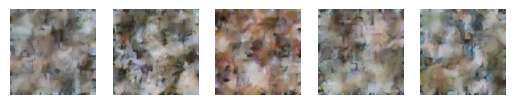

Epoch=11 | Train Loss: 0.2788088023662567
Epoch=12 | Train Loss: 0.15858139842748642
Epoch=13 | Train Loss: 0.24115417897701263
Epoch=14 | Train Loss: 0.2733742520213127
Epoch=15 | Train Loss: 0.4133661687374115
Epoch=16 | Train Loss: 0.35386117547750473
Epoch=17 | Train Loss: 0.2667645402252674
Epoch=18 | Train Loss: 0.3094356283545494
Epoch=19 | Train Loss: 0.20697034522891045
Epoch=20 | Train Loss: 0.2002893090248108
tensor([1, 0, 1, 1, 1], device='cuda:0')


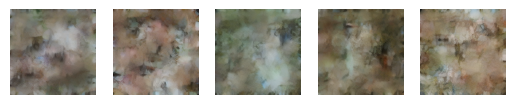

Epoch=21 | Train Loss: 0.16097275167703629
Epoch=22 | Train Loss: 0.16482915729284286
Epoch=23 | Train Loss: 0.1120220497250557
Epoch=24 | Train Loss: 0.23173202574253082
Epoch=25 | Train Loss: 0.15710045024752617
Epoch=26 | Train Loss: 0.1610848307609558
Epoch=27 | Train Loss: 0.24373608827590942
Epoch=28 | Train Loss: 0.1093820109963417
Epoch=29 | Train Loss: 0.20601342618465424
Epoch=30 | Train Loss: 0.3204563111066818
tensor([0, 1, 0, 1, 0], device='cuda:0')


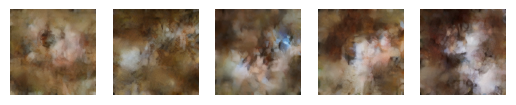

Epoch=31 | Train Loss: 0.13268962875008583
Epoch=32 | Train Loss: 0.19815614819526672
Epoch=33 | Train Loss: 0.10173467174172401
Epoch=34 | Train Loss: 0.09268072247505188
Epoch=35 | Train Loss: 0.33724142611026764
Epoch=36 | Train Loss: 0.2902649901807308
Epoch=37 | Train Loss: 0.21264594048261642
Epoch=38 | Train Loss: 0.2176603376865387
Epoch=39 | Train Loss: 0.34606800973415375
Epoch=40 | Train Loss: 0.23305607959628105
tensor([1, 0, 0, 0, 0], device='cuda:0')


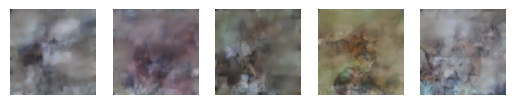

Epoch=41 | Train Loss: 0.1558464579284191
Epoch=42 | Train Loss: 0.20534680783748627
Epoch=43 | Train Loss: 0.3849032446742058
Epoch=44 | Train Loss: 0.20945405215024948
Epoch=45 | Train Loss: 0.17520840093493462
Epoch=46 | Train Loss: 0.2767269238829613
Epoch=47 | Train Loss: 0.14760786294937134
Epoch=48 | Train Loss: 0.34090563654899597
Epoch=49 | Train Loss: 0.17421109974384308
Epoch=50 | Train Loss: 0.24655234813690186
tensor([0, 0, 0, 0, 1], device='cuda:0')


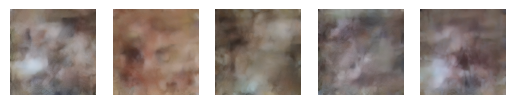

Epoch=51 | Train Loss: 0.144827488809824
Epoch=52 | Train Loss: 0.2549188956618309
Epoch=53 | Train Loss: 0.21748529374599457
Epoch=54 | Train Loss: 0.22739703208208084
Epoch=55 | Train Loss: 0.1726718246936798
Epoch=56 | Train Loss: 0.26475856453180313
Epoch=57 | Train Loss: 0.1514122299849987
Epoch=58 | Train Loss: 0.35938969254493713
Epoch=59 | Train Loss: 0.13782017305493355
Epoch=60 | Train Loss: 0.2526659071445465
tensor([1, 0, 0, 0, 0], device='cuda:0')


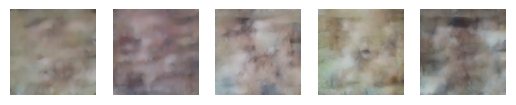

Epoch=61 | Train Loss: 0.08340027183294296
Epoch=62 | Train Loss: 0.18831168115139008
Epoch=63 | Train Loss: 0.25509028136730194
Epoch=64 | Train Loss: 0.0814224649220705
Epoch=65 | Train Loss: 0.143948657438159
Epoch=66 | Train Loss: 0.13758260384202003
Epoch=67 | Train Loss: 0.17450328543782234
Epoch=68 | Train Loss: 0.282226100564003
Epoch=69 | Train Loss: 0.1691819690167904
Epoch=70 | Train Loss: 0.20215952210128307
tensor([1, 1, 0, 0, 1], device='cuda:0')


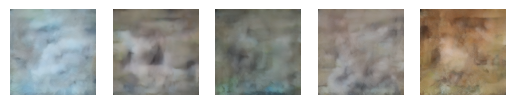

Epoch=71 | Train Loss: 0.33787156641483307
Epoch=72 | Train Loss: 0.12556019239127636
Epoch=73 | Train Loss: 0.09122245758771896
Epoch=74 | Train Loss: 0.11362704448401928
Epoch=75 | Train Loss: 0.1961410492658615
Epoch=76 | Train Loss: 0.2944117709994316
Epoch=77 | Train Loss: 0.14747469872236252
Epoch=78 | Train Loss: 0.11237333342432976
Epoch=79 | Train Loss: 0.1677800603210926
Epoch=80 | Train Loss: 0.08620020188391209
tensor([0, 0, 1, 1, 1], device='cuda:0')


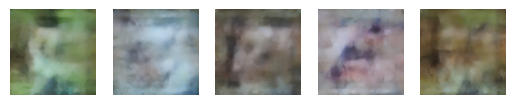

Epoch=81 | Train Loss: 0.14797811582684517
Epoch=82 | Train Loss: 0.19180181622505188
Epoch=83 | Train Loss: 0.12205427512526512
Epoch=84 | Train Loss: 0.18597090803086758
Epoch=85 | Train Loss: 0.08200988173484802
Epoch=86 | Train Loss: 0.0905662253499031
Epoch=87 | Train Loss: 0.11692906729876995
Epoch=88 | Train Loss: 0.24681780487298965
Epoch=89 | Train Loss: 0.2630692794919014
Epoch=90 | Train Loss: 0.09951433539390564
tensor([0, 0, 1, 1, 1], device='cuda:0')


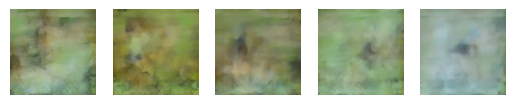

Epoch=91 | Train Loss: 0.12444535084068775
Epoch=92 | Train Loss: 0.11970843374729156
Epoch=93 | Train Loss: 0.11122599244117737
Epoch=94 | Train Loss: 0.10677159205079079
Epoch=95 | Train Loss: 0.21676217764616013
Epoch=96 | Train Loss: 0.1989736557006836
Epoch=97 | Train Loss: 0.1468153167515993
Epoch=98 | Train Loss: 0.08186047151684761
Epoch=99 | Train Loss: 0.1385614424943924
Epoch=100 | Train Loss: 0.06713815778493881
tensor([0, 0, 0, 1, 0], device='cuda:0')


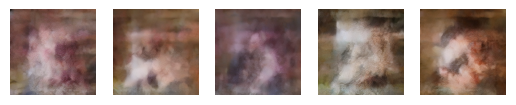

Epoch=101 | Train Loss: 0.05779830925166607
Epoch=102 | Train Loss: 0.0813877321779728
Epoch=103 | Train Loss: 0.1658154372125864
Epoch=104 | Train Loss: 0.0690023098140955
Epoch=105 | Train Loss: 0.06694629602134228
Epoch=106 | Train Loss: 0.10314481146633625
Epoch=107 | Train Loss: 0.1755944937467575
Epoch=108 | Train Loss: 0.12620531022548676
Epoch=109 | Train Loss: 0.24311135709285736
Epoch=110 | Train Loss: 0.13655728101730347
tensor([1, 0, 1, 1, 1], device='cuda:0')


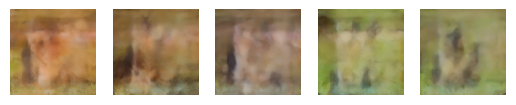

Epoch=111 | Train Loss: 0.09469856880605221
Epoch=112 | Train Loss: 0.08343464508652687
Epoch=113 | Train Loss: 0.23456743359565735
Epoch=114 | Train Loss: 0.08912556245923042
Epoch=115 | Train Loss: 0.07918936014175415
Epoch=116 | Train Loss: 0.08160965517163277
Epoch=117 | Train Loss: 0.07887738943099976
Epoch=118 | Train Loss: 0.11091311275959015
Epoch=119 | Train Loss: 0.08880229480564594
Epoch=120 | Train Loss: 0.17546077817678452
tensor([0, 1, 1, 0, 0], device='cuda:0')


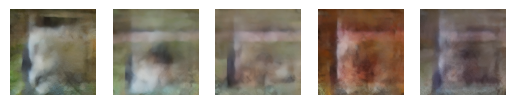

Epoch=121 | Train Loss: 0.15750625357031822
Epoch=122 | Train Loss: 0.14884533360600471
Epoch=123 | Train Loss: 0.1499990550801158
Epoch=124 | Train Loss: 0.10720037296414375
Epoch=125 | Train Loss: 0.19467444717884064
Epoch=126 | Train Loss: 0.04084137175232172
Epoch=127 | Train Loss: 0.13119328394532204
Epoch=128 | Train Loss: 0.13746512681245804
Epoch=129 | Train Loss: 0.14764219895005226
Epoch=130 | Train Loss: 0.1755720004439354
tensor([0, 0, 0, 0, 1], device='cuda:0')


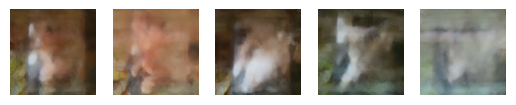

Epoch=131 | Train Loss: 0.04929031617939472
Epoch=132 | Train Loss: 0.056521594524383545
Epoch=133 | Train Loss: 0.15594608709216118
Epoch=134 | Train Loss: 0.14490442350506783
Epoch=135 | Train Loss: 0.10967814363539219
Epoch=136 | Train Loss: 0.09891247376799583
Epoch=137 | Train Loss: 0.1194835677742958
Epoch=138 | Train Loss: 0.2007090449333191
Epoch=139 | Train Loss: 0.06329459883272648
Epoch=140 | Train Loss: 0.11556544527411461
tensor([0, 0, 0, 0, 0], device='cuda:0')


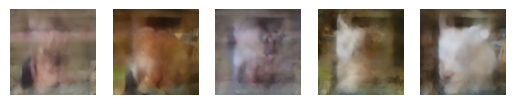

Epoch=141 | Train Loss: 0.16394864954054356
Epoch=142 | Train Loss: 0.12968498095870018
Epoch=143 | Train Loss: 0.09011164866387844
Epoch=144 | Train Loss: 0.055633099749684334
Epoch=145 | Train Loss: 0.02684523444622755
Epoch=146 | Train Loss: 0.16146478801965714
Epoch=147 | Train Loss: 0.09819447249174118
Epoch=148 | Train Loss: 0.18219661340117455
Epoch=149 | Train Loss: 0.219806008040905
Epoch=150 | Train Loss: 0.04367542173713446
tensor([0, 1, 1, 0, 0], device='cuda:0')


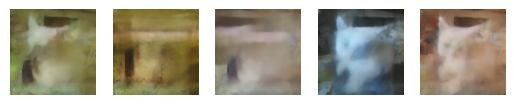

Epoch=151 | Train Loss: 0.07283006235957146
Epoch=152 | Train Loss: 0.048306139186024666
Epoch=153 | Train Loss: 0.10680892691016197
Epoch=154 | Train Loss: 0.09462890587747097
Epoch=155 | Train Loss: 0.06561125628650188
Epoch=156 | Train Loss: 0.07251062896102667
Epoch=157 | Train Loss: 0.02614378184080124
Epoch=158 | Train Loss: 0.0421542152762413
Epoch=159 | Train Loss: 0.13600943610072136
Epoch=160 | Train Loss: 0.042129949666559696
tensor([0, 0, 1, 1, 0], device='cuda:0')


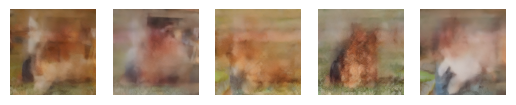

Epoch=161 | Train Loss: 0.16358091309666634
Epoch=162 | Train Loss: 0.05447453260421753
Epoch=163 | Train Loss: 0.09301843121647835
Epoch=164 | Train Loss: 0.0401889830827713
Epoch=165 | Train Loss: 0.14107700064778328
Epoch=166 | Train Loss: 0.0859332662075758
Epoch=167 | Train Loss: 0.22446681931614876
Epoch=168 | Train Loss: 0.06482220534235239
Epoch=169 | Train Loss: 0.03941123839467764
Epoch=170 | Train Loss: 0.072990408167243
tensor([0, 1, 0, 0, 0], device='cuda:0')


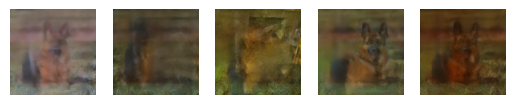

Epoch=171 | Train Loss: 0.14555995166301727
Epoch=172 | Train Loss: 0.05262999888509512
Epoch=173 | Train Loss: 0.13472644239664078
Epoch=174 | Train Loss: 0.22331243753433228
Epoch=175 | Train Loss: 0.11676006764173508
Epoch=176 | Train Loss: 0.06526097748428583
Epoch=177 | Train Loss: 0.13368340581655502
Epoch=178 | Train Loss: 0.19966798275709152
Epoch=179 | Train Loss: 0.09609540365636349
Epoch=180 | Train Loss: 0.0823722667992115
tensor([1, 0, 1, 1, 1], device='cuda:0')


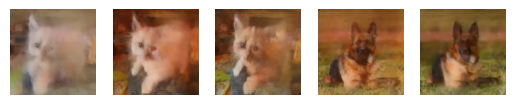

Epoch=181 | Train Loss: 0.03422005567699671
Epoch=182 | Train Loss: 0.048562461510300636
Epoch=183 | Train Loss: 0.029904295690357685
Epoch=184 | Train Loss: 0.05214140564203262
Epoch=185 | Train Loss: 0.06424360163509846
Epoch=186 | Train Loss: 0.02532709389925003
Epoch=187 | Train Loss: 0.034745135344564915
Epoch=188 | Train Loss: 0.06958015821874142
Epoch=189 | Train Loss: 0.0451571699231863
Epoch=190 | Train Loss: 0.04629833437502384
tensor([0, 1, 0, 0, 1], device='cuda:0')


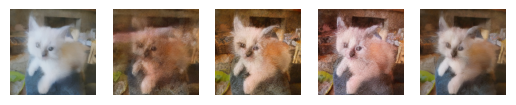

Epoch=191 | Train Loss: 0.0460268585011363
Epoch=192 | Train Loss: 0.08554908819496632
Epoch=193 | Train Loss: 0.06250412296503782
Epoch=194 | Train Loss: 0.08432172052562237
Epoch=195 | Train Loss: 0.1307157203555107
Epoch=196 | Train Loss: 0.021696980111300945
Epoch=197 | Train Loss: 0.14958166517317295
Epoch=198 | Train Loss: 0.03758393693715334
Epoch=199 | Train Loss: 0.05799724720418453
Epoch=200 | Train Loss: 0.069948460906744
tensor([1, 1, 0, 1, 1], device='cuda:0')


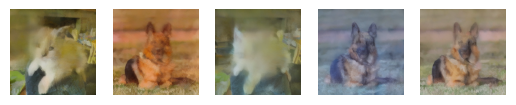

Epoch=201 | Train Loss: 0.09607701003551483
Epoch=202 | Train Loss: 0.2003981303423643
Epoch=203 | Train Loss: 0.059765344485640526
Epoch=204 | Train Loss: 0.054752158001065254
Epoch=205 | Train Loss: 0.08568991161882877
Epoch=206 | Train Loss: 0.04102139361202717
Epoch=207 | Train Loss: 0.037876516580581665
Epoch=208 | Train Loss: 0.12903373129665852
Epoch=209 | Train Loss: 0.0357881523668766
Epoch=210 | Train Loss: 0.05019809026271105
tensor([0, 1, 0, 0, 0], device='cuda:0')


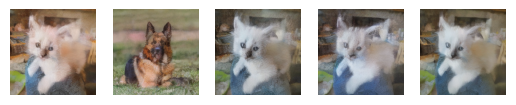

Epoch=211 | Train Loss: 0.11507228575646877
Epoch=212 | Train Loss: 0.12327077612280846
Epoch=213 | Train Loss: 0.01732263481244445
Epoch=214 | Train Loss: 0.04076183866709471
Epoch=215 | Train Loss: 0.15950914099812508
Epoch=216 | Train Loss: 0.02516177576035261
Epoch=217 | Train Loss: 0.04348151572048664
Epoch=218 | Train Loss: 0.080203827470541
Epoch=219 | Train Loss: 0.14956704434007406
Epoch=220 | Train Loss: 0.0638577751815319
tensor([0, 0, 0, 0, 0], device='cuda:0')


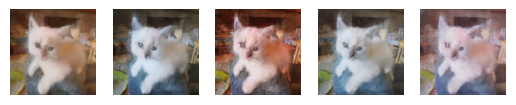

Epoch=221 | Train Loss: 0.16021627187728882
Epoch=222 | Train Loss: 0.02726489631459117
Epoch=223 | Train Loss: 0.02558452356606722
Epoch=224 | Train Loss: 0.1285781804472208
Epoch=225 | Train Loss: 0.11870827525854111
Epoch=226 | Train Loss: 0.07261074613779783
Epoch=227 | Train Loss: 0.1792556196451187
Epoch=228 | Train Loss: 0.0243732500821352
Epoch=229 | Train Loss: 0.06990089546889067
Epoch=230 | Train Loss: 0.11139414273202419
tensor([1, 0, 0, 0, 1], device='cuda:0')


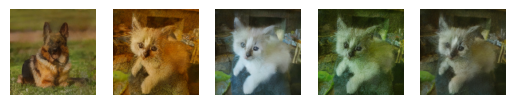

Epoch=231 | Train Loss: 0.06270483136177063
Epoch=232 | Train Loss: 0.03235779795795679
Epoch=233 | Train Loss: 0.12951655220240355
Epoch=234 | Train Loss: 0.04246182553470135
Epoch=235 | Train Loss: 0.12286227568984032
Epoch=236 | Train Loss: 0.0333561385050416
Epoch=237 | Train Loss: 0.05578184500336647
Epoch=238 | Train Loss: 0.03523636516183615
Epoch=239 | Train Loss: 0.03747779596596956
Epoch=240 | Train Loss: 0.027369783259928226
tensor([1, 1, 0, 0, 1], device='cuda:0')


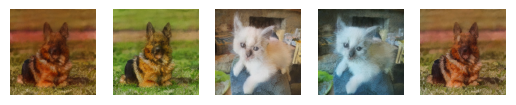

Epoch=241 | Train Loss: 0.09746347740292549
Epoch=242 | Train Loss: 0.030872142408043146
Epoch=243 | Train Loss: 0.01852409355342388
Epoch=244 | Train Loss: 0.03893873933702707
Epoch=245 | Train Loss: 0.04268899653106928
Epoch=246 | Train Loss: 0.03376465756446123
Epoch=247 | Train Loss: 0.048298731446266174
Epoch=248 | Train Loss: 0.020214353688061237
Epoch=249 | Train Loss: 0.022390759550035
Epoch=250 | Train Loss: 0.13834543153643608
tensor([1, 0, 1, 1, 1], device='cuda:0')


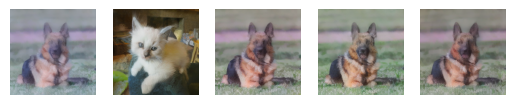

Epoch=251 | Train Loss: 0.022985611110925674
Epoch=252 | Train Loss: 0.019970182329416275
Epoch=253 | Train Loss: 0.09743141010403633
Epoch=254 | Train Loss: 0.024233032017946243
Epoch=255 | Train Loss: 0.0422931807115674
Epoch=256 | Train Loss: 0.01646546134725213
Epoch=257 | Train Loss: 0.02124603185802698
Epoch=258 | Train Loss: 0.024922573007643223
Epoch=259 | Train Loss: 0.05834294855594635
Epoch=260 | Train Loss: 0.04215977992862463
tensor([1, 0, 1, 1, 1], device='cuda:0')


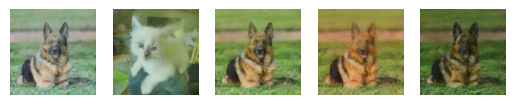

Epoch=261 | Train Loss: 0.019776958040893078
Epoch=262 | Train Loss: 0.10419341176748276
Epoch=263 | Train Loss: 0.033267092891037464
Epoch=264 | Train Loss: 0.042318335734307766
Epoch=265 | Train Loss: 0.10398463252931833
Epoch=266 | Train Loss: 0.08493938483297825
Epoch=267 | Train Loss: 0.09405283629894257
Epoch=268 | Train Loss: 0.020889366045594215
Epoch=269 | Train Loss: 0.025145051535218954
Epoch=270 | Train Loss: 0.0636429050937295
tensor([0, 1, 0, 1, 1], device='cuda:0')


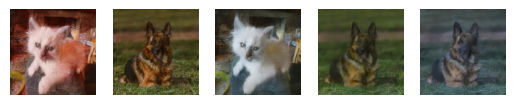

Epoch=271 | Train Loss: 0.032113692723214626
Epoch=272 | Train Loss: 0.21765907667577267
Epoch=273 | Train Loss: 0.12970581138506532
Epoch=274 | Train Loss: 0.02228784142062068
Epoch=275 | Train Loss: 0.033479636535048485
Epoch=276 | Train Loss: 0.12830488942563534
Epoch=277 | Train Loss: 0.04068777058273554
Epoch=278 | Train Loss: 0.028746909461915493
Epoch=279 | Train Loss: 0.052819122560322285
Epoch=280 | Train Loss: 0.02319824928417802
tensor([1, 0, 1, 0, 1], device='cuda:0')


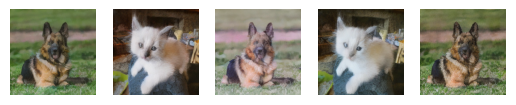

Epoch=281 | Train Loss: 0.09072764683514833
Epoch=282 | Train Loss: 0.017859636805951595
Epoch=283 | Train Loss: 0.1241140216588974
Epoch=284 | Train Loss: 0.09124068636447191
Epoch=285 | Train Loss: 0.02530685579404235
Epoch=286 | Train Loss: 0.020202239509671926
Epoch=287 | Train Loss: 0.027210526168346405
Epoch=288 | Train Loss: 0.09981817379593849
Epoch=289 | Train Loss: 0.12416140362620354
Epoch=290 | Train Loss: 0.0320321312174201
tensor([1, 1, 0, 0, 0], device='cuda:0')


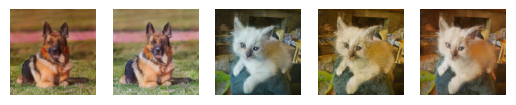

Epoch=291 | Train Loss: 0.10281104873865843
Epoch=292 | Train Loss: 0.06883012969046831
Epoch=293 | Train Loss: 0.09102191962301731
Epoch=294 | Train Loss: 0.05662635061889887
Epoch=295 | Train Loss: 0.12033279798924923
Epoch=296 | Train Loss: 0.08148274291306734
Epoch=297 | Train Loss: 0.11025997065007687
Epoch=298 | Train Loss: 0.0568751934915781
Epoch=299 | Train Loss: 0.07839250937104225
Epoch=300 | Train Loss: 0.020961955189704895
tensor([1, 0, 0, 0, 0], device='cuda:0')


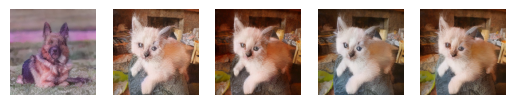

Epoch=301 | Train Loss: 0.14816443901509047
Epoch=302 | Train Loss: 0.024524464271962643
Epoch=303 | Train Loss: 0.08456434775143862
Epoch=304 | Train Loss: 0.03154275752604008
Epoch=305 | Train Loss: 0.12426912365481257
Epoch=306 | Train Loss: 0.017241178546100855
Epoch=307 | Train Loss: 0.027764510363340378
Epoch=308 | Train Loss: 0.09674632269889116
Epoch=309 | Train Loss: 0.030149731785058975
Epoch=310 | Train Loss: 0.01963122747838497
tensor([0, 1, 1, 1, 0], device='cuda:0')


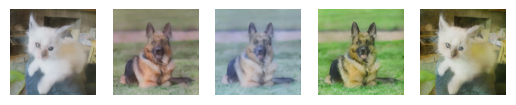

Epoch=311 | Train Loss: 0.07733139675110579
Epoch=312 | Train Loss: 0.03405730985105038
Epoch=313 | Train Loss: 0.0358920325525105
Epoch=314 | Train Loss: 0.032854716293513775
Epoch=315 | Train Loss: 0.012482381891459227
Epoch=316 | Train Loss: 0.034852005541324615
Epoch=317 | Train Loss: 0.023153919726610184
Epoch=318 | Train Loss: 0.022739498876035213
Epoch=319 | Train Loss: 0.16333194077014923
Epoch=320 | Train Loss: 0.024200073443353176
tensor([0, 0, 0, 0, 0], device='cuda:0')


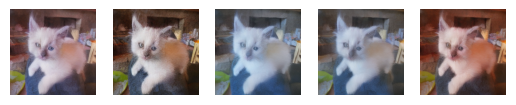

Epoch=321 | Train Loss: 0.05026113893836737
Epoch=322 | Train Loss: 0.011075371876358986
Epoch=323 | Train Loss: 0.06140911020338535
Epoch=324 | Train Loss: 0.01819903450086713
Epoch=325 | Train Loss: 0.013895473908632994
Epoch=326 | Train Loss: 0.01817743480205536
Epoch=327 | Train Loss: 0.02603590488433838
Epoch=328 | Train Loss: 0.015407842118293047
Epoch=329 | Train Loss: 0.1258584875613451
Epoch=330 | Train Loss: 0.029519205912947655
tensor([1, 1, 1, 1, 1], device='cuda:0')


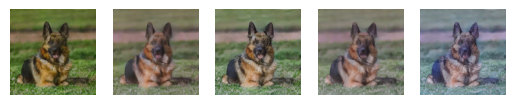

Epoch=331 | Train Loss: 0.1022720467299223
Epoch=332 | Train Loss: 0.015501468442380428
Epoch=333 | Train Loss: 0.047979854978621006
Epoch=334 | Train Loss: 0.0171231790445745
Epoch=335 | Train Loss: 0.10678267106413841
Epoch=336 | Train Loss: 0.0397550230845809
Epoch=337 | Train Loss: 0.05427202628925443
Epoch=338 | Train Loss: 0.1834065169095993
Epoch=339 | Train Loss: 0.0431389263831079
Epoch=340 | Train Loss: 0.017031955998390913
tensor([1, 1, 0, 1, 0], device='cuda:0')


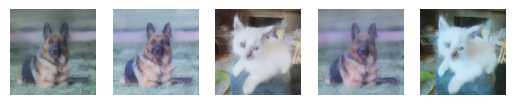

Epoch=341 | Train Loss: 0.15707415994256735
Epoch=342 | Train Loss: 0.09977660467848182
Epoch=343 | Train Loss: 0.05021071247756481
Epoch=344 | Train Loss: 0.0771209467202425
Epoch=345 | Train Loss: 0.14343693852424622
Epoch=346 | Train Loss: 0.14194506220519543
Epoch=347 | Train Loss: 0.044376700185239315
Epoch=348 | Train Loss: 0.03440196346491575
Epoch=349 | Train Loss: 0.10817117244005203
Epoch=350 | Train Loss: 0.18670253455638885
tensor([0, 1, 1, 1, 0], device='cuda:0')


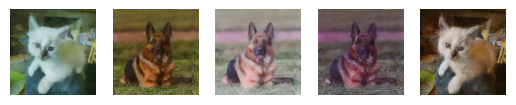

Epoch=351 | Train Loss: 0.03366592898964882
Epoch=352 | Train Loss: 0.017877222038805485
Epoch=353 | Train Loss: 0.06112807244062424
Epoch=354 | Train Loss: 0.03189678629860282
Epoch=355 | Train Loss: 0.13265965692698956
Epoch=356 | Train Loss: 0.06711671315133572
Epoch=357 | Train Loss: 0.013841294217854738
Epoch=358 | Train Loss: 0.050005254335701466
Epoch=359 | Train Loss: 0.05173530615866184
Epoch=360 | Train Loss: 0.05401954986155033
tensor([0, 0, 1, 0, 1], device='cuda:0')


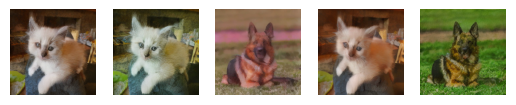

Epoch=361 | Train Loss: 0.01827365322969854
Epoch=362 | Train Loss: 0.058006600476801395
Epoch=363 | Train Loss: 0.015581184066832066
Epoch=364 | Train Loss: 0.10749417124316096
Epoch=365 | Train Loss: 0.016063446644693613
Epoch=366 | Train Loss: 0.09310483932495117
Epoch=367 | Train Loss: 0.022337115835398436
Epoch=368 | Train Loss: 0.0854593999683857
Epoch=369 | Train Loss: 0.08739315997809172
Epoch=370 | Train Loss: 0.017592579126358032
tensor([1, 1, 1, 0, 1], device='cuda:0')


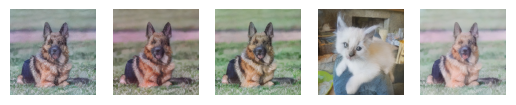

Epoch=371 | Train Loss: 0.06008823588490486
Epoch=372 | Train Loss: 0.05682693235576153
Epoch=373 | Train Loss: 0.01083027757704258
Epoch=374 | Train Loss: 0.1610991507768631
Epoch=375 | Train Loss: 0.05207896465435624
Epoch=376 | Train Loss: 0.01599540375173092
Epoch=377 | Train Loss: 0.01778989378362894
Epoch=378 | Train Loss: 0.051310441456735134
Epoch=379 | Train Loss: 0.14436009526252747
Epoch=380 | Train Loss: 0.07207477651536465
tensor([0, 0, 0, 1, 0], device='cuda:0')


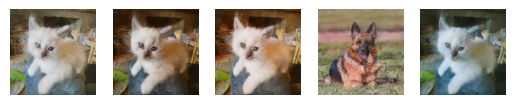

Epoch=381 | Train Loss: 0.08597912639379501
Epoch=382 | Train Loss: 0.06916610337793827
Epoch=383 | Train Loss: 0.034236859530210495
Epoch=384 | Train Loss: 0.01063756924122572
Epoch=385 | Train Loss: 0.04819402704015374
Epoch=386 | Train Loss: 0.03175172582268715
Epoch=387 | Train Loss: 0.03305698558688164
Epoch=388 | Train Loss: 0.03067051339894533
Epoch=389 | Train Loss: 0.016320498194545507
Epoch=390 | Train Loss: 0.009594204369932413
tensor([1, 1, 1, 0, 1], device='cuda:0')


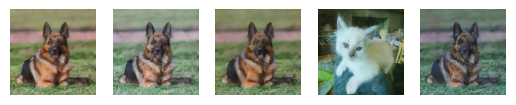

Epoch=391 | Train Loss: 0.015905202832072973
Epoch=392 | Train Loss: 0.016128696501255035
Epoch=393 | Train Loss: 0.044775931630283594
Epoch=394 | Train Loss: 0.019177135080099106
Epoch=395 | Train Loss: 0.010368857299908996
Epoch=396 | Train Loss: 0.033019207417964935
Epoch=397 | Train Loss: 0.014403749257326126
Epoch=398 | Train Loss: 0.025350661715492606
Epoch=399 | Train Loss: 0.04083944717422128
Epoch=400 | Train Loss: 0.024185344576835632
tensor([0, 1, 1, 0, 0], device='cuda:0')


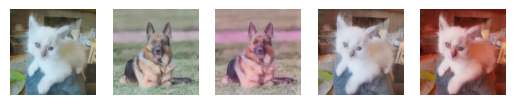

Epoch=401 | Train Loss: 0.01867344742640853
Epoch=402 | Train Loss: 0.02122730016708374
Epoch=403 | Train Loss: 0.007818564772605896
Epoch=404 | Train Loss: 0.026273423805832863
Epoch=405 | Train Loss: 0.014923067297786474
Epoch=406 | Train Loss: 0.0226085321046412
Epoch=407 | Train Loss: 0.010080261155962944
Epoch=408 | Train Loss: 0.025942496955394745
Epoch=409 | Train Loss: 0.030367054045200348
Epoch=410 | Train Loss: 0.01038016751408577
tensor([1, 0, 1, 0, 1], device='cuda:0')


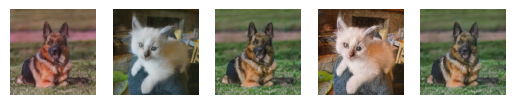

Epoch=411 | Train Loss: 0.015172645915299654
Epoch=412 | Train Loss: 0.006767054321244359
Epoch=413 | Train Loss: 0.010532124433666468
Epoch=414 | Train Loss: 0.02361436327919364
Epoch=415 | Train Loss: 0.010855090338736773
Epoch=416 | Train Loss: 0.070838937535882
Epoch=417 | Train Loss: 0.050424802117049694
Epoch=418 | Train Loss: 0.017625654116272926
Epoch=419 | Train Loss: 0.039263259153813124
Epoch=420 | Train Loss: 0.021450458094477654
tensor([0, 0, 1, 0, 0], device='cuda:0')


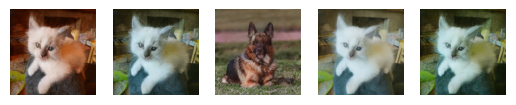

Epoch=421 | Train Loss: 0.025958150625228882
Epoch=422 | Train Loss: 0.01686275703832507
Epoch=423 | Train Loss: 0.059900226537138224
Epoch=424 | Train Loss: 0.017889028880745173
Epoch=425 | Train Loss: 0.05802874267101288
Epoch=426 | Train Loss: 0.01935320906341076
Epoch=427 | Train Loss: 0.1049600257538259
Epoch=428 | Train Loss: 0.028151427395641804
Epoch=429 | Train Loss: 0.10392835736274719
Epoch=430 | Train Loss: 0.03745109587907791
tensor([1, 1, 0, 1, 1], device='cuda:0')


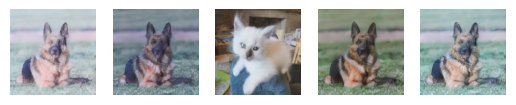

Epoch=431 | Train Loss: 0.05269985273480415
Epoch=432 | Train Loss: 0.05898026516661048
Epoch=433 | Train Loss: 0.03965104138478637
Epoch=434 | Train Loss: 0.04044658038765192
Epoch=435 | Train Loss: 0.05981511157006025
Epoch=436 | Train Loss: 0.013397577218711376
Epoch=437 | Train Loss: 0.052632277831435204
Epoch=438 | Train Loss: 0.013682624325156212
Epoch=439 | Train Loss: 0.03866593446582556
Epoch=440 | Train Loss: 0.011160901514813304
tensor([0, 0, 1, 1, 0], device='cuda:0')


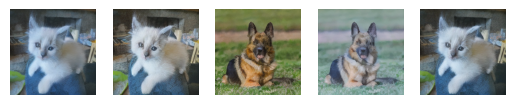

Epoch=441 | Train Loss: 0.01672942074947059
Epoch=442 | Train Loss: 0.11093394504860044
Epoch=443 | Train Loss: 0.05653658276423812
Epoch=444 | Train Loss: 0.040659849531948566
Epoch=445 | Train Loss: 0.025596019811928272
Epoch=446 | Train Loss: 0.047627389430999756
Epoch=447 | Train Loss: 0.016084549017250538
Epoch=448 | Train Loss: 0.04877143353223801
Epoch=449 | Train Loss: 0.03399590356275439
Epoch=450 | Train Loss: 0.023256481625139713
tensor([0, 1, 0, 0, 0], device='cuda:0')


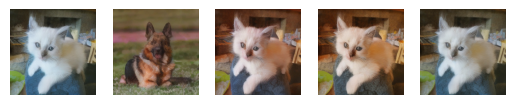

Epoch=451 | Train Loss: 0.04415523633360863
Epoch=452 | Train Loss: 0.012029800098389387
Epoch=453 | Train Loss: 0.04417723510414362
Epoch=454 | Train Loss: 0.03340215748175979
Epoch=455 | Train Loss: 0.025029634591192007
Epoch=456 | Train Loss: 0.01445382134988904
Epoch=457 | Train Loss: 0.01282693026587367
Epoch=458 | Train Loss: 0.05662176525220275
Epoch=459 | Train Loss: 0.016816232353448868
Epoch=460 | Train Loss: 0.022101815789937973
tensor([1, 1, 0, 0, 0], device='cuda:0')


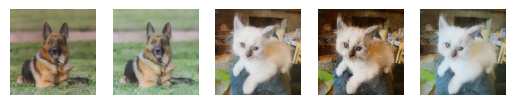

Epoch=461 | Train Loss: 0.08248355239629745
Epoch=462 | Train Loss: 0.022757526952773333
Epoch=463 | Train Loss: 0.028437152039259672
Epoch=464 | Train Loss: 0.04742793086916208
Epoch=465 | Train Loss: 0.0109154530800879
Epoch=466 | Train Loss: 0.010208690539002419
Epoch=467 | Train Loss: 0.06039106845855713
Epoch=468 | Train Loss: 0.01798021700233221
Epoch=469 | Train Loss: 0.06915527768433094
Epoch=470 | Train Loss: 0.07432588469237089
tensor([0, 0, 1, 1, 0], device='cuda:0')


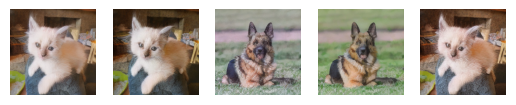

Epoch=471 | Train Loss: 0.10636000661179423
Epoch=472 | Train Loss: 0.020338634494692087
Epoch=473 | Train Loss: 0.05270975409075618
Epoch=474 | Train Loss: 0.018073538318276405
Epoch=475 | Train Loss: 0.0679846303537488
Epoch=476 | Train Loss: 0.06356019340455532
Epoch=477 | Train Loss: 0.03724540676921606
Epoch=478 | Train Loss: 0.05768642155453563
Epoch=479 | Train Loss: 0.027088981587439775
Epoch=480 | Train Loss: 0.01309552788734436
tensor([1, 1, 0, 1, 1], device='cuda:0')


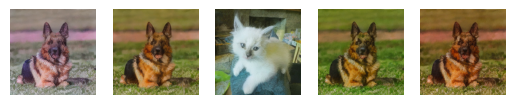

Epoch=481 | Train Loss: 0.04162053810432553
Epoch=482 | Train Loss: 0.012895755702629685
Epoch=483 | Train Loss: 0.00941634876653552
Epoch=484 | Train Loss: 0.02473684772849083
Epoch=485 | Train Loss: 0.01970426831394434
Epoch=486 | Train Loss: 0.01982533372938633
Epoch=487 | Train Loss: 0.10781348869204521
Epoch=488 | Train Loss: 0.010541229043155909
Epoch=489 | Train Loss: 0.02845083735883236
Epoch=490 | Train Loss: 0.04241756349802017
tensor([0, 1, 1, 0, 1], device='cuda:0')


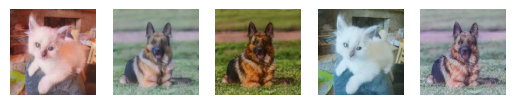

Epoch=491 | Train Loss: 0.08552279323339462
Epoch=492 | Train Loss: 0.15425473358482122
Epoch=493 | Train Loss: 0.025822413619607687
Epoch=494 | Train Loss: 0.08442152896896005
Epoch=495 | Train Loss: 0.09963537007570267
Epoch=496 | Train Loss: 0.08437235513702035
Epoch=497 | Train Loss: 0.014719853643327951
Epoch=498 | Train Loss: 0.13663353770971298
Epoch=499 | Train Loss: 0.04232547525316477


In [12]:
train(unet, epochs=500)

In [13]:
def plot_losses(train_losses):
    batches = range(1, len(train_losses) + 1)

    plt.plot(batches, train_losses, label="Training Loss")
    
    plt.title("Training Loss")
    plt.xlabel("batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

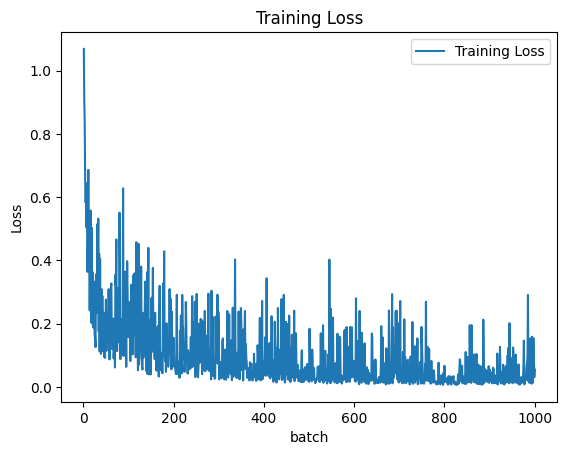

In [14]:
plot_losses(losses)